Importa o modelo a ser fatiado e mapeado

In [1]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
Total de [criando as camadas] : 0.3094191551208496
salvando as camadas
Total de [salvando as camadas] : 0.09832191467285156
Total de [Fase 0: ] : 0.4080922603607178


Paredes Finas

In [2]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO: anotar todos os (não fechou contorno)
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.00015020370483398438
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.05572700500488281
Total de [Criando paredes finas] : 12.495545387268066
Total de [Fase 1: Camada: 0] : 12.516524076461792


Contornos

In [3]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 9
Total de [Criando Lvls] : 7.5526604652404785
Criando os loops
Total de [Criando os loops] : 4.901464462280273
Criando regiões de influência
Total de [Criando regiões de influência] : 1.3192474842071533
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 2.4163339138031006
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:2382 maior void:0.33877038895859474Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:1929 maior void:0.5872020075282308Bw -> aceito
['Lvl_002', 0, 0] Perdendo total:1636 maior void:0.5131744040150564Bw -> aceito
['Lvl_003', 0, 0] Perdendo total:1637 maior void:0.5131744040150564Bw -> aceito
['Lvl_004', 0, 0] Perdendo total:9614 maior void:5.503136762860728Bw -> bloqueado
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 2] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 3] Perdendo total:4

Pontes

In [4]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        c.prohibited_areas = last_prohibited_areas
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas))
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
# %reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 16.940767288208008
Criando pontes de Zigzag
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
Total de [Criando pontes de Zigzag] : 47.91030669212341
Criando pontes de Crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqui

Zigzags

In [5]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 15.532755374908447
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.21062135696411133
Total de [Fase 4: Camada: 0] : 16.52534055709839


Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 1.6121325492858887


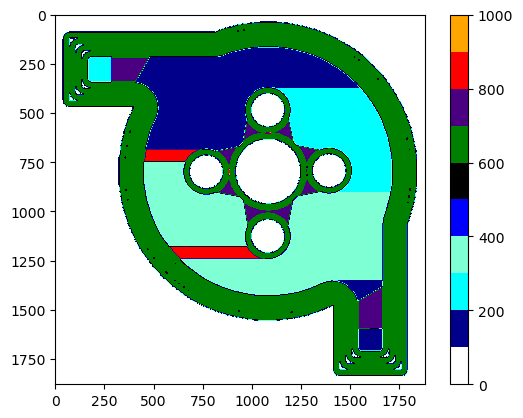

In [6]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [7]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.35102176666259766
Total de [Making offset routes] : 13.692113876342773


Rotas de pontes

In [8]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes


/home/matheus/Downloads/Tangran3/TangranV2/components/bottleneck.py:1339: RuntimeWarning: invalid value encountered in divide
  v1_hat = v1_vec / np.linalg.norm(v1_vec)
/home/matheus/Downloads/Tangran3/TangranV2/components/bottleneck.py:1346: RuntimeWarning: invalid value encountered in divide
  v2_hat = v2_vec / np.linalg.norm(v2_vec)
/home/matheus/Downloads/Tangran3/TangranV2/components/bottleneck.py:1335: RuntimeWarning: invalid value encountered in divide
  o_hat = o_vec / np.linalg.norm(o_vec)


salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.5612492561340332
Total de [Making bridges routes] : 46.209099769592285


Rotas de Ziguezague

In [9]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 17.883002996444702
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.44914889335632324
fazendo as tres opções:
Total de [fazendo as tres opções:] : 14.24062466621399
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.497053861618042
fazendo as tres opções:
Total de [fazendo as tres opções:] : 15.146840333938599
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.4424452781677246
fazendo as tres opções:
Total de [fazendo as tres opções:] : 0.07354259490966797
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.22373414039611816
fazendo as tres opções:
Total de [fazendo as tres opções:] : 28.624271631240845
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.5659999847412109
fazendo as tres opções:
Total de [fazendo as tres opções:] : 14.279967069625854
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.445213

In [1]:
#WEAVING

import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[internal_weaving] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(internal_weaving, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 4.364070415496826
Achando os contatos
Total de [Achando os contatos] : 32.901548624038696
criando os weavings
Total de [criando os weavings] : 22.242105722427368
Total de [gerando preenchimentos oscilatórios] : 67.38243222236633
salvando rotas
Total de [salvando rotas] : 0.3993399143218994
Total de [Fase 5 b] : 67.78252601623535


Rotas de Thin Walls

In [2]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.00028252601623535156
Total de [Making thin walls routes] : 0.11976981163024902
Total de [Fase 5] : 0.12015414237976074


Unificando rotas EXTERNAS nas camadas

In [3]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
33
Total de [Encontrando ponto de união ext-int] : 0.5566000938415527
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 26.473807096481323
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 4.3392181396484375e-05
Total de [Conectando rotas externas] : 29.5415461063385
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.3265495300292969
Total de [Fase 6] : 29.868663549423218


Unificando rotas INTERNAS nas camadas

In [4]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 29.174872159957886
Conectando pontes de zigzag
salto:  [1578, 1574]
salto:  [1004, 952]
salto:  [250, 270]
Total de [Conectando pontes de zigzag] : 3.757824659347534
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.4227924346923828
Total de [Fase 7] : 35.84704947471619


Unindo rotas de thin walls

In [5]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.002142190933227539
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.23991823196411133
Total de [Fase 8] : 0.3353879451751709


Unindo todas as rotas e criando codigo G

In [6]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall] = gui.ask_parameters_Gcode()
camadas = folders.load_layers_hdf5()

internal_trees = []
external_trees = []
tw_trees = []
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        
for c in camadas:
    c.close_final_path(folders)
    for isl in c.islands:
        internal_trees.append([list(x) for x in isl.internal_tree_route.sequence])
        external_trees.append([list(x) for x in isl.external_tree_route.sequence])
        tw_trees.append([list(x) for x in isl.thinwalls_tree_route.sequence])

with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               internal_trees,
                               external_trees,
                               tw_trees,
                               )
%reset_selective -f "camadas"

Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.061287879943847656
Cuspindo o Gcode
trocou para 1
trocou para 0
Total de [Cuspindo o Gcode] : 5.1926093101501465


In [7]:
import numpy as np
camadas = folders.load_layers_hdf5()
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
        print(internal_trees)
print([235,807] in internal_trees)

[[310, 443], [309, 444], [308, 445], [307, 445], [306, 446], [305, 446], [304, 447], [303, 447], [302, 448], [301, 448], [300, 449], [299, 450], [298, 450], [297, 451], [296, 451], [295, 452], [294, 452], [293, 453], [292, 454], [291, 454], [290, 455], [289, 455], [288, 456], [287, 456], [286, 457], [285, 457], [284, 458], [283, 459], [282, 459], [281, 460], [280, 460], [279, 461], [278, 461], [277, 462], [276, 463], [275, 463], [274, 464], [273, 464], [272, 465], [271, 465], [270, 466], [269, 467], [268, 467], [267, 468], [266, 468], [265, 469], [264, 469], [263, 470], [262, 470], [261, 471], [260, 472], [259, 472], [258, 473], [257, 473], [256, 474], [255, 474], [254, 475], [253, 476], [252, 476], [251, 477], [250, 478], [250, 479], [250, 480], [250, 481], [250, 482], [250, 483], [250, 484], [250, 485], [250, 486], [250, 487], [250, 488], [250, 489], [250, 490], [250, 491], [250, 492], [249, 493], [248, 493], [247, 493], [246, 493], [245, 493], [244, 493], [243, 493], [242, 493], [24

In [8]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [9]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)